# This notebook explores data features for linear regression

In [56]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from collections import defaultdict

import scipy.stats as stats

from sklearn.metrics import mean_absolute_error

import operator

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### 1. Read in df and fill Nan with column mean

In [17]:
df_all = pd.read_pickle('features_data_for_regression.pkl')

In [18]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 1553
Data columns (total 23 columns):
best_match_score       293 non-null float64
__id_left              293 non-null object
__id_right             293 non-null object
city_left              293 non-null object
state_left             293 non-null object
pct_time_in_traffic    293 non-null float64
bus_per_sq_mi          26 non-null float64
percip_inches          236 non-null float64
density2019            109 non-null float64
state_tax              239 non-null float64
city_tax               74 non-null float64
total_tax              74 non-null float64
year_F                 238 non-null float64
walk_score             262 non-null float64
transit_score          141 non-null float64
bike_score             254 non-null float64
population             262 non-null float64
GeoFips                293 non-null object
GeoName                293 non-null object
2017                   293 non-null float64
city_right             

In [19]:
df_all.head()

,best_match_score,__id_left,__id_right,city_left,state_left,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,...,walk_score,transit_score,bike_score,population,GeoFips,GeoName,2017,city_right,state_right,gdp_per_cap_17
0,0.276741,0_left,211_right,los angeles,CA,0.12,68.7,12.8,3343.0,0.075,...,67.4,51.5,55.1,3792621.0,31080,"Los Angeles-Long Beach-Anaheim, CA (Metropolit...",67763.0,los angeles-long beach-anaheim,CA,67763.0
1,0.288864,1_left,250_right,new york city,NY,0.13,79.0,49.9,11056.0,0.040,...,NaN,NaN,NaN,NaN,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",71084.0,new york-newark-jersey city,NY-NJ-PA,71084.0
2,0.212240,2_left,311_right,san francisco,CA,0.12,47.9,20.7,7388.0,0.075,...,86.0,80.4,70.7,805235.0,41860,"San Francisco-Oakland-Hayward, CA (Metropolita...",89978.0,san francisco-oakland-hayward,CA,89978.0
3,0.006353,3_left,18_right,atlanta,GA,0.10,NaN,49.7,1450.0,0.040,...,49.2,46.0,41.4,420003.0,12060,"Atlanta-Sandy Springs-Roswell, GA (Metropolita...",56840.0,atlanta-sandy springs-roswell,GA,56840.0
4,-0.087855,4_left,170_right,miami,FL,0.09,33.1,61.9,5276.0,0.060,...,79.2,57.2,63.0,399457.0,27260,"Jacksonville, FL (Metropolitan Statistical Area)",43741.0,jacksonville,FL,43741.0


In [20]:
df_all.describe()

,best_match_score,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,city_tax,total_tax,year_F,walk_score,transit_score,bike_score,population,2017,gdp_per_cap_17
count,293.000000,293.000000,26.000000,236.000000,109.000000,239.000000,74.000000,74.000000,238.000000,262.000000,141.000000,254.000000,2.620000e+02,293.000000,293.000000
mean,0.166245,0.055017,30.161538,37.755890,1628.000000,0.058409,0.019637,0.076972,58.111765,43.773282,33.614184,45.052362,2.183454e+05,45301.423208,45301.423208
std,0.189251,0.025810,14.688147,14.065715,1504.914412,0.011035,0.016364,0.012521,8.351748,13.904752,12.564932,12.170208,3.786471e+05,12172.601778,12172.601778
min,-0.261831,0.010000,16.500000,4.200000,341.000000,0.029000,0.000000,0.045000,38.900000,14.000000,0.000000,17.000000,1.714000e+04,20509.000000,20509.000000
25%,0.001043,0.040000,25.050000,30.847500,774.000000,0.052125,0.007062,0.070000,51.500000,34.000000,27.000000,37.000000,5.753600e+04,37614.000000,37614.000000
50%,0.198179,0.050000,26.300000,40.245000,1219.000000,0.060000,0.018750,0.078875,57.150000,41.000000,32.000000,43.950000,1.049370e+05,42349.000000,42349.000000
75%,0.294168,0.070000,32.550000,47.972500,1859.000000,0.062500,0.026875,0.084512,64.100000,51.000000,38.100000,51.500000,2.027158e+05,52270.000000,52270.000000
max,0.630480,0.140000,79.000000,66.220000,11056.000000,0.075000,0.060000,0.102500,77.600000,86.000000,80.400000,90.000000,3.792621e+06,89978.000000,89978.000000


In [6]:
gdp = pd.read_csv('cityGDP.csv')

In [7]:
gdp[['city','state']] = gdp['GeoName'].str.split(', ', n=1, expand=True)

In [8]:
gdp['state'] = [str(x) for x in gdp['state']]
gdp['city'] = [str(x) for x in gdp['city']]
gdp['gdp_per_cap_17'] = [float(x) for x in gdp['2017']]

In [9]:
gdp['state'] = [x.split(' (')[0] for x in gdp['state']] 
gdp['city'] = [x.lower() for x in gdp['city']] 

In [10]:
gdp.dtypes

GeoFips            object
GeoName            object
2017              float64
city               object
state              object
gdp_per_cap_17    float64
dtype: object

In [11]:
gdp.head()

,GeoFips,GeoName,2017,city,state,gdp_per_cap_17
0,998,United States (Metropolitan Portion),54410.0,united states (metropolitan portion),None,54410.0
1,10180,"Abilene, TX (Metropolitan Statistical Area)",39648.0,abilene,TX,39648.0
2,10420,"Akron, OH (Metropolitan Statistical Area)",46036.0,akron,OH,46036.0
3,10500,"Albany, GA (Metropolitan Statistical Area)",30798.0,albany,GA,30798.0
4,10540,"Albany, OR (Metropolitan Statistical Area)",29027.0,albany,OR,29027.0


In [12]:
gdp.to_pickle('gdp_by_city.pkl')

In [13]:
len(gdp)

388

In [14]:
import fuzzymatcher
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [23]:
df_all.columns

Index(['best_match_score', '__id_left', '__id_right', 'city_left',
       'state_left', 'pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches',
       'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F',
       'walk_score', 'transit_score', 'bike_score', 'population', 'GeoFips',
       'GeoName', '2017', 'city_right', 'state_right', 'gdp_per_cap_17'],
      dtype='object')

In [24]:
#df_all = pd.merge(df_all, gdp, on=['city','state'], how= 'left')
#df_all = fuzzymatcher.fuzzy_left_join(df_all, gdp, left_on=['city','state'], right_on=['city','state'])

df_all = pd.read_pickle('features_data_all_vars.pkl')

In [25]:
df_all.columns

Index(['best_match_score', '__id_left', '__id_right', 'city_left',
       'state_left', 'pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches',
       'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F',
       'walk_score', 'transit_score', 'bike_score', 'population', 'GeoFips',
       'GeoName', '2017', 'city_right', 'state_right', 'gdp_per_cap_17'],
      dtype='object')

In [ ]:
df.info()

In [ ]:
df_all.to_pickle('features_data_all_vars.pkl')

In [ ]:
df_all[df_all.gdp_per_cap_17.isna() == True]

In [26]:
df = df_all.iloc[:,5:]
df = df[df.columns.drop(['city_right','state_right','GeoFips','GeoName','2017'])]
#df = df[df.columns.drop('city_right')]
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [27]:
df.describe()

,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,city_tax,total_tax,year_F,walk_score,transit_score,bike_score,population,gdp_per_cap_17
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,2.930000e+02,293.000000
mean,0.055017,30.161538,37.755890,1628.000000,0.058409,0.019637,0.076972,58.111765,43.773282,33.614184,45.052362,2.183454e+05,45301.423208
std,0.025810,4.297794,12.618401,915.234228,0.009962,0.008182,0.006260,7.524197,13.145953,8.700270,11.328355,3.579838e+05,12172.601778
min,0.010000,16.500000,4.200000,341.000000,0.029000,0.000000,0.045000,38.900000,14.000000,0.000000,17.000000,1.714000e+04,20509.000000
25%,0.040000,30.161538,34.440000,1628.000000,0.056000,0.019637,0.076972,52.400000,35.000000,33.000000,38.100000,6.213400e+04,37614.000000
50%,0.050000,30.161538,37.755890,1628.000000,0.060000,0.019637,0.076972,58.111765,42.700000,33.614184,45.052362,1.159420e+05,42349.000000
75%,0.070000,30.161538,46.150000,1628.000000,0.062500,0.019637,0.076972,62.300000,50.000000,33.614184,50.000000,2.183454e+05,52270.000000
max,0.140000,79.000000,66.220000,11056.000000,0.075000,0.060000,0.102500,77.600000,86.000000,80.400000,90.000000,3.792621e+06,89978.000000


In [28]:
df_all['bus_per_sq_mi'].mean()

30.161538461538456

In [29]:
df_all.sort_values(by='bus_per_sq_mi', ascending = False).head()

,best_match_score,__id_left,__id_right,city_left,state_left,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,...,walk_score,transit_score,bike_score,population,GeoFips,GeoName,2017,city_right,state_right,gdp_per_cap_17
1,0.288864,1_left,250_right,new york city,NY,0.13,79.0,49.9,11056.0,0.0400,...,NaN,NaN,NaN,NaN,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",71084.0,new york-newark-jersey city,NY-NJ-PA,71084.0
0,0.276741,0_left,211_right,los angeles,CA,0.12,68.7,12.8,3343.0,0.0750,...,67.4,51.5,55.1,3792621.0,31080,"Los Angeles-Long Beach-Anaheim, CA (Metropolit...",67763.0,los angeles-long beach-anaheim,CA,67763.0
2,0.212240,2_left,311_right,san francisco,CA,0.12,47.9,20.7,7388.0,0.0750,...,86.0,80.4,70.7,805235.0,41860,"San Francisco-Oakland-Hayward, CA (Metropolita...",89978.0,san francisco-oakland-hayward,CA,89978.0
28,0.025205,6_left,43_right,boston,MA,0.14,34.9,43.8,5549.0,0.0625,...,80.9,72.6,69.0,617594.0,14460,"Boston-Cambridge-Newton, MA-NH (Metropolitan S...",78465.0,boston-cambridge-newton,MA-NH,78465.0
4,-0.087855,4_left,170_right,miami,FL,0.09,33.1,61.9,5276.0,0.0600,...,79.2,57.2,63.0,399457.0,27260,"Jacksonville, FL (Metropolitan Statistical Area)",43741.0,jacksonville,FL,43741.0


#### 2. Explore features distributions and correlations

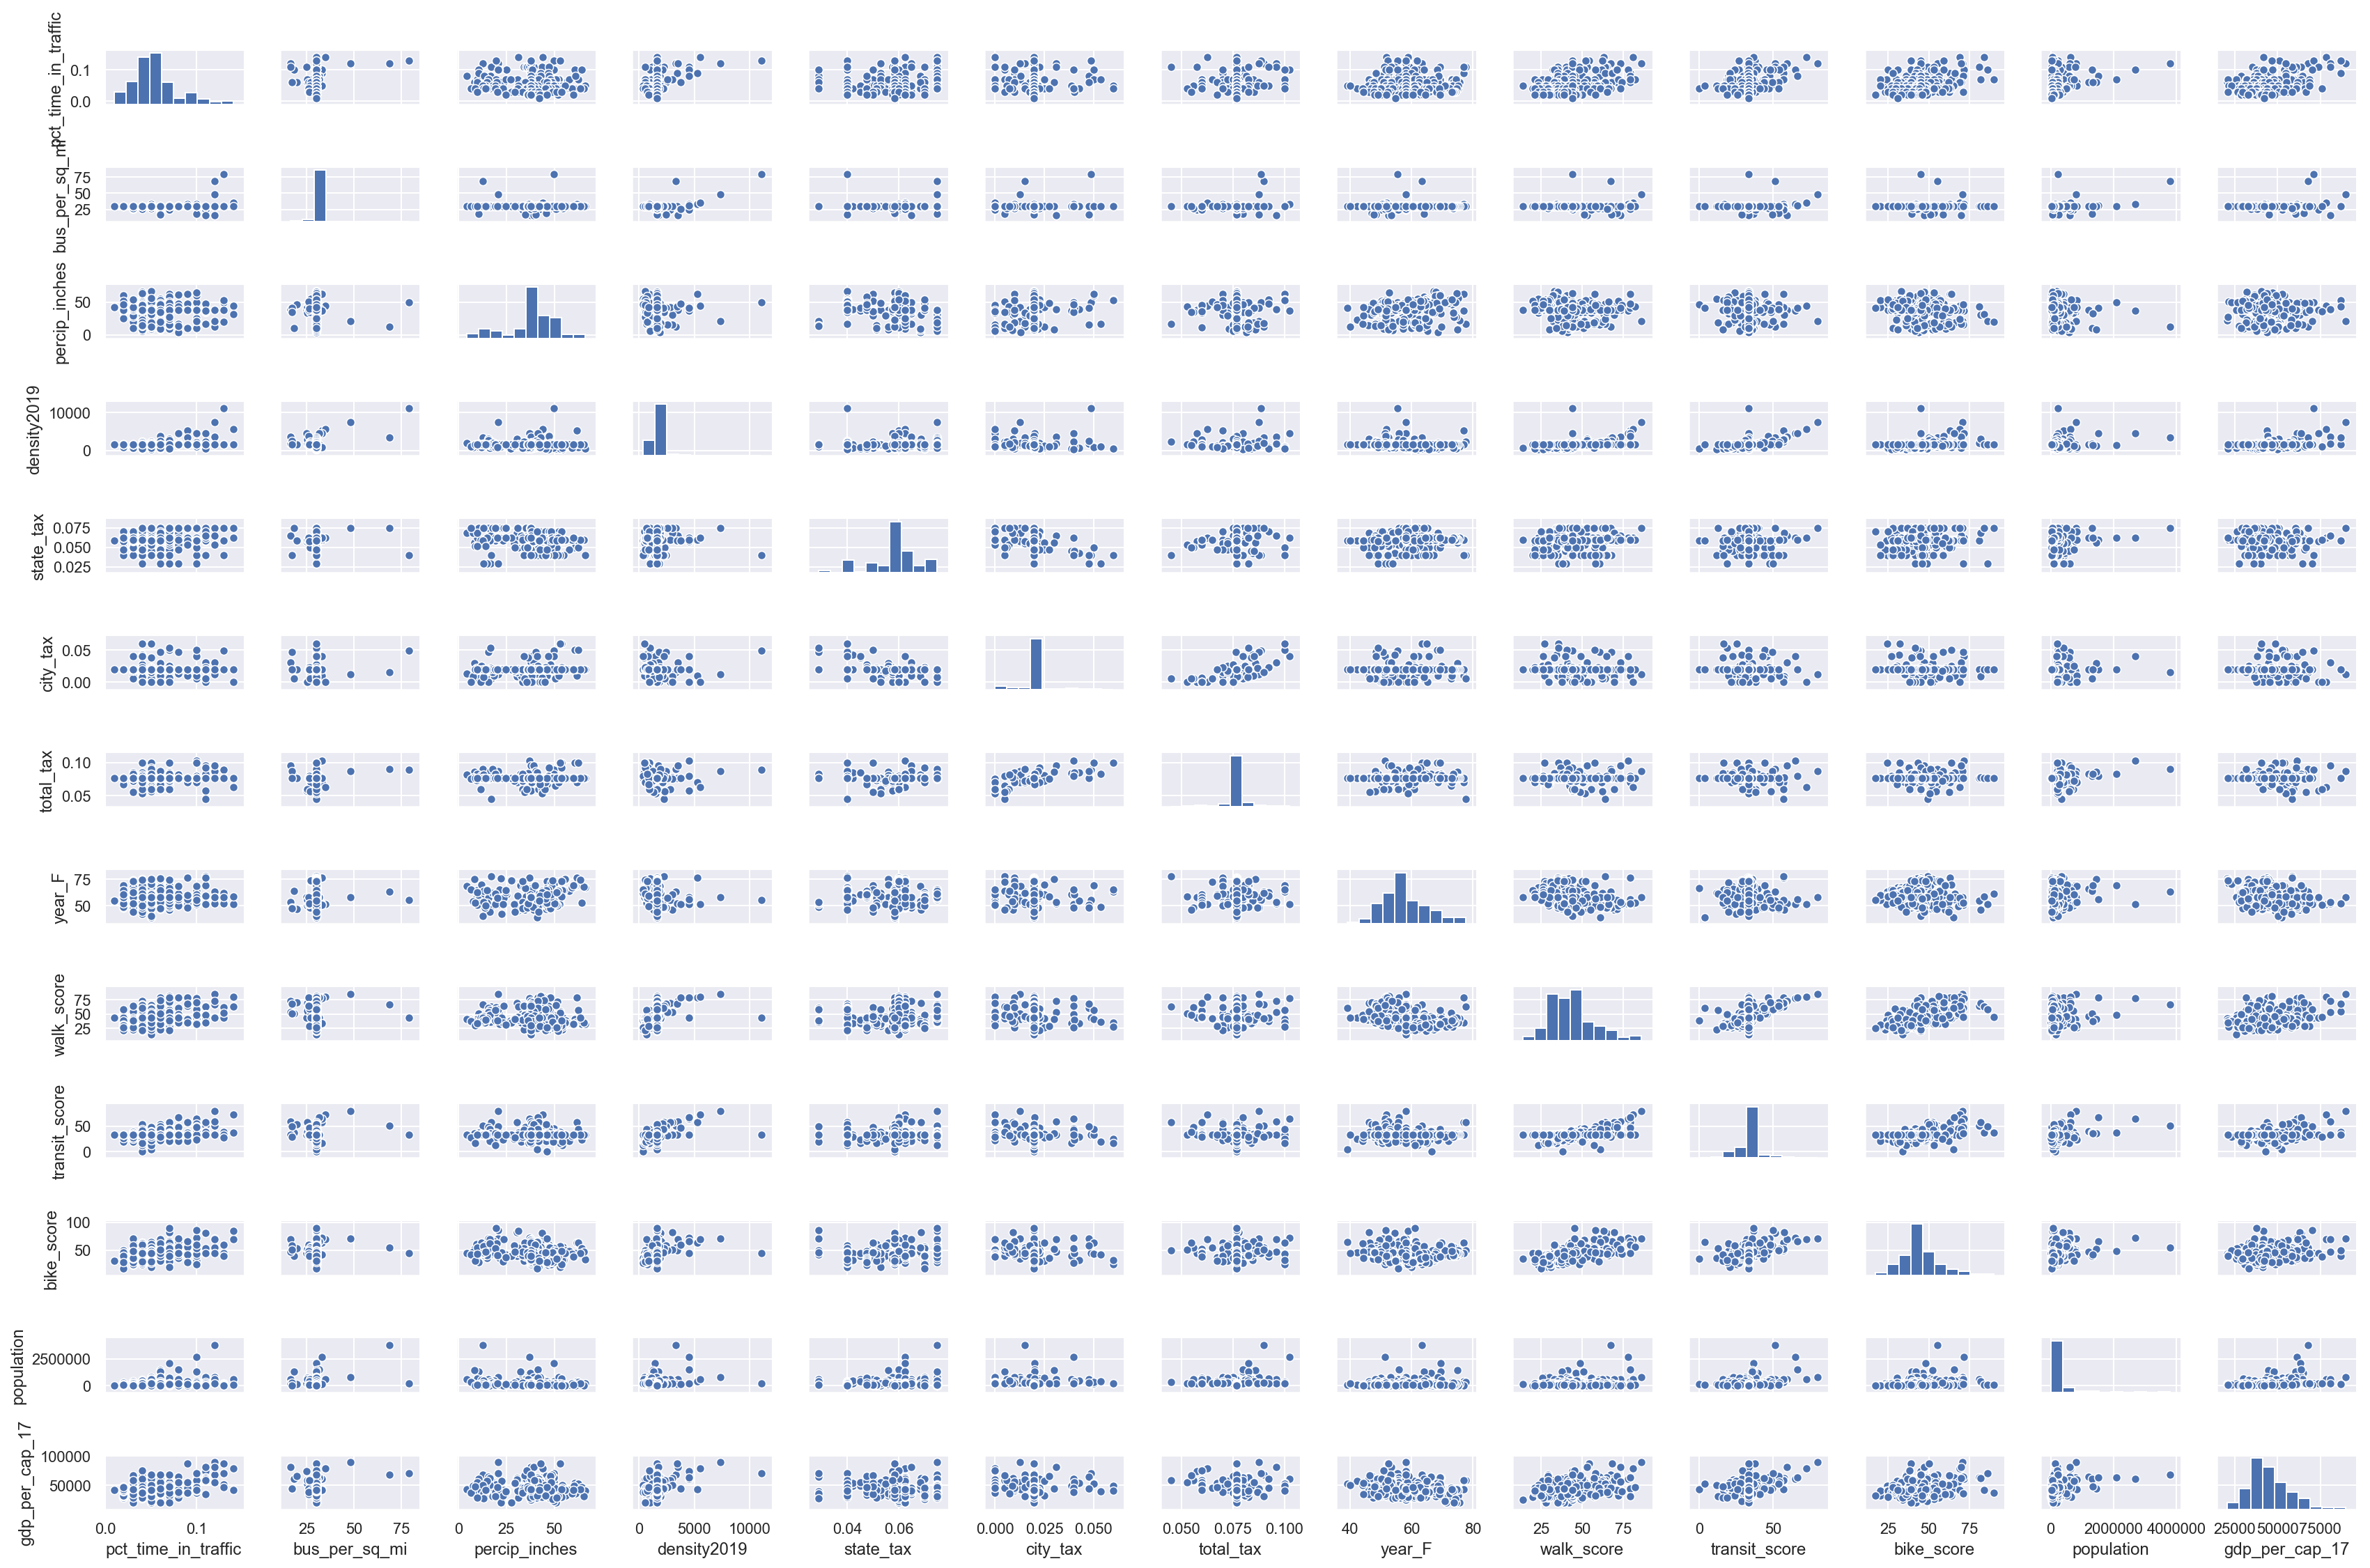

In [30]:
sns.pairplot(df, height=1.2, aspect=1.5);

**i. Take log of population**

In [31]:
df['log_pop'] = log(df['population'])

In [32]:
df.to_pickle('features_data_for_regression.pkl')

In [33]:
df['log_pop'].describe()

count    293.000000
mean      11.733522
std        0.987711
min        9.749170
25%       11.037049
50%       11.660845
75%       12.293833
max       15.148568
Name: log_pop, dtype: float64

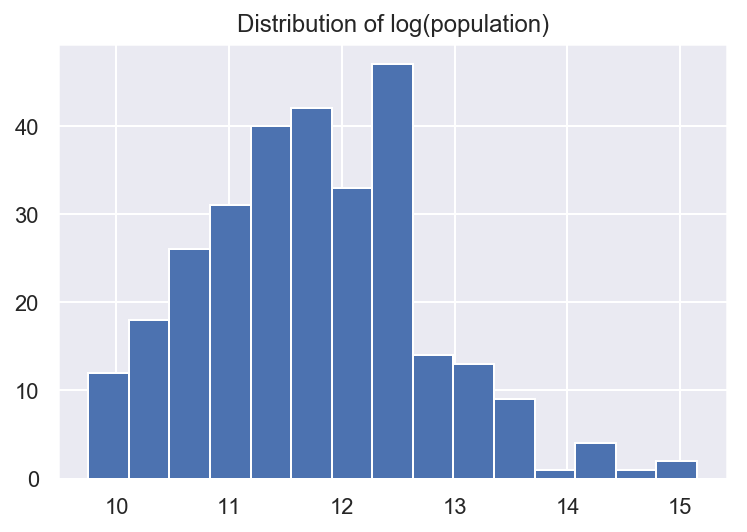

In [34]:
plt.hist(df['log_pop'], bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of log(population)")
plt.show()

**ii. Make polynomials based on some pairplots**

*a. Population density looks like y=x^(1/2)*

In [35]:
df.columns

Index(['pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches', 'density2019',
       'state_tax', 'city_tax', 'total_tax', 'year_F', 'walk_score',
       'transit_score', 'bike_score', 'population', 'gdp_per_cap_17',
       'log_pop'],
      dtype='object')

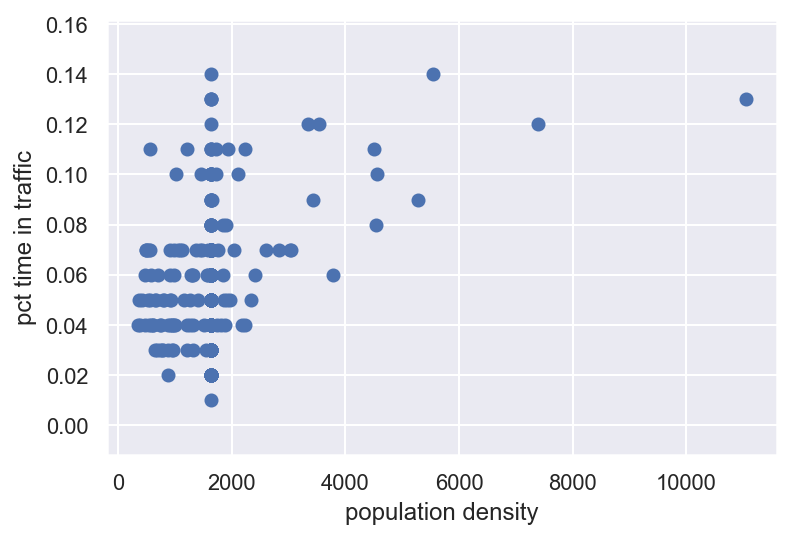

In [36]:
x = df['density2019']
y = df['pct_time_in_traffic']
plt.scatter(x,y)

plt.xlabel('population density')
plt.ylabel('pct time in traffic')
plt.show()

In [37]:
import math
df['pop_density_1/2'] = [math.sqrt(x) for x in df['density2019']]

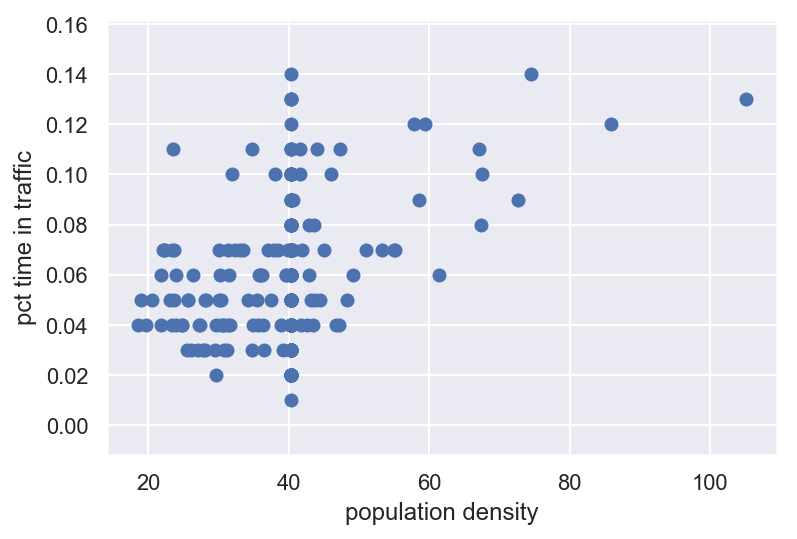

In [38]:
x = df['pop_density_1/2']
y = df['pct_time_in_traffic']
plt.scatter(x,y)

plt.xlabel('population density')
plt.ylabel('pct time in traffic')
plt.show()

**Interaction terms**

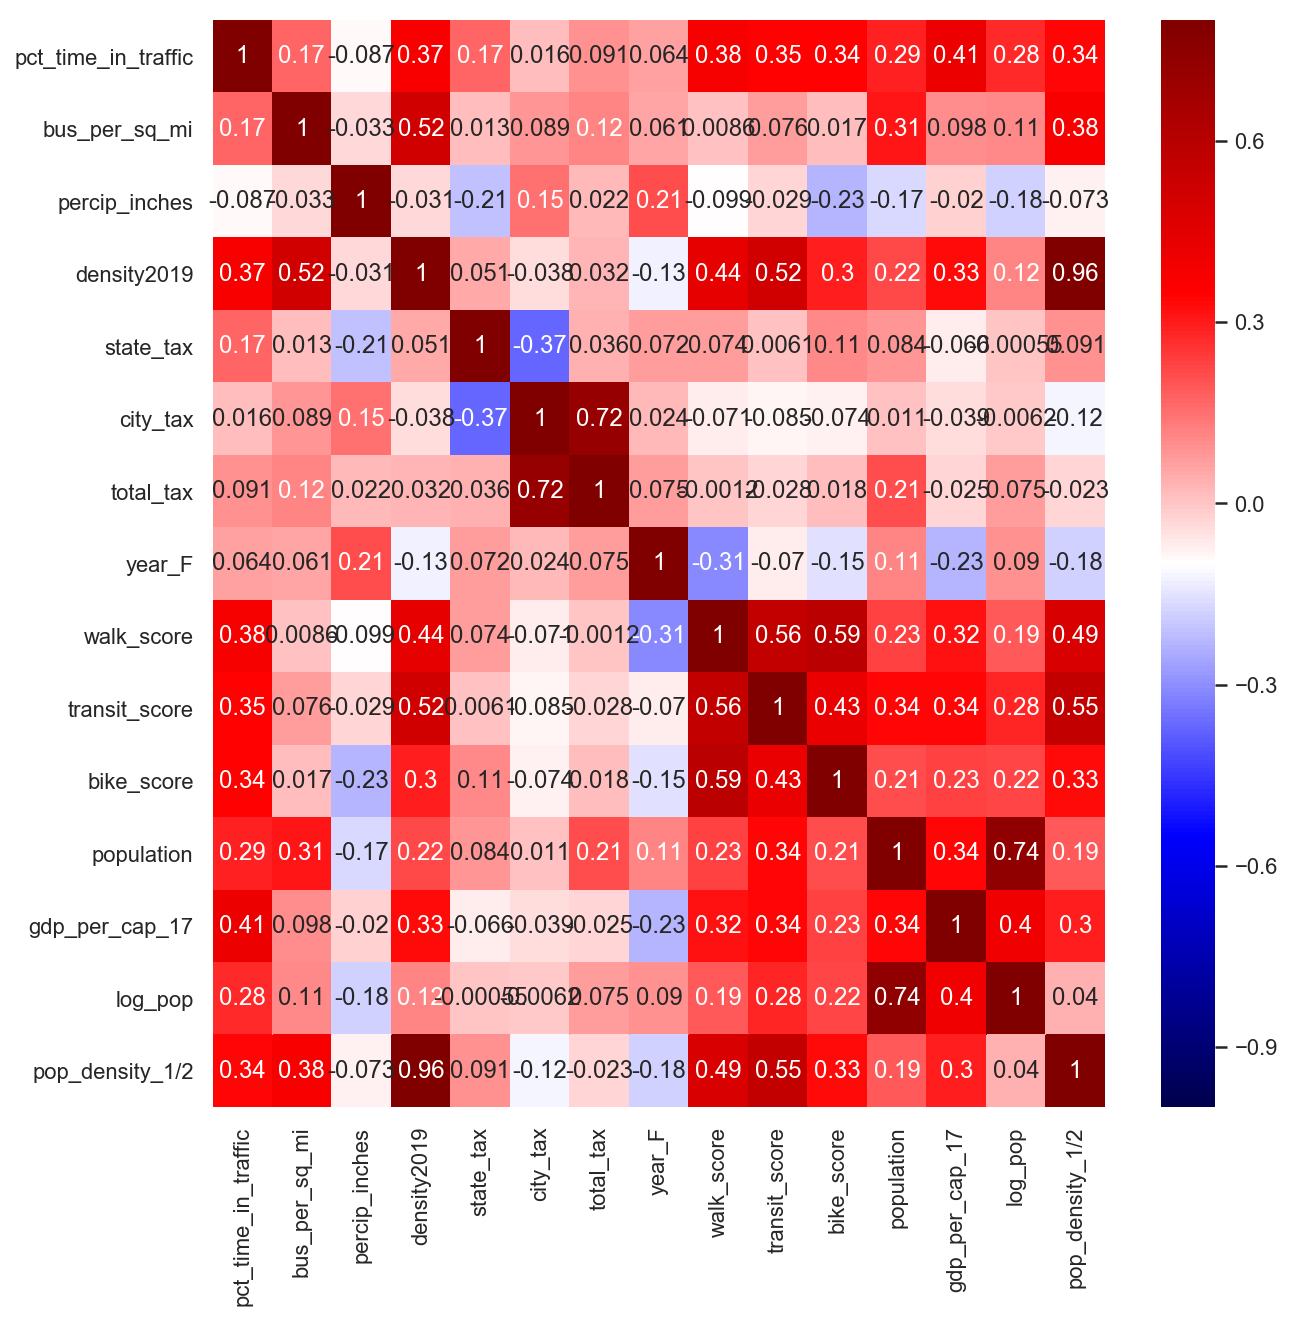

In [67]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=.8, ax=ax);
fig.savefig("heatmap.png")

In [41]:
corrs = {}
cols = ['bike_score', 'walk_score', 'pct_time_in_traffic', 'gdp_per_cap_17','bus_per_sq_mi', 'percip_inches', 'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F', 'transit_score', 'population', 'log_pop', 'pop_density_1/2']
for x in cols:
    cols = [w for w in cols if w != x]
    for w in cols:
        corrs[(x, w)] = df[x].corr(df[w])
results = [(x, v.round(2)) for x, v in corrs.items() if corrs[x] > 0.5]
results


[(('bike_score', 'walk_score'), 0.59),
 (('walk_score', 'transit_score'), 0.56),
 (('bus_per_sq_mi', 'density2019'), 0.52),
 (('density2019', 'transit_score'), 0.52),
 (('density2019', 'pop_density_1/2'), 0.96),
 (('city_tax', 'total_tax'), 0.72),
 (('transit_score', 'pop_density_1/2'), 0.55),
 (('population', 'log_pop'), 0.74)]

*ii. Make interaction terms*

In [71]:
interacts = []
for i in range(len(results)):    
    col1 = results[i][0][0]
    col2 = results[i][0][1]
    col_interact = col1+'_x_'+col2
    interacts.append(col_interact)
    df[col_interact] = df[col1]*df[col2]
interacts

['bike_score_x_walk_score',
 'walk_score_x_transit_score',
 'bus_per_sq_mi_x_density2019',
 'density2019_x_transit_score',
 'density2019_x_pop_density_1/2',
 'city_tax_x_total_tax',
 'transit_score_x_pop_density_1/2',
 'population_x_log_pop']

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
X.head()

*Check VIF for Xs*

In [42]:
X_all = add_constant(df.drop('bike_score',axis=1))
X_all.head()

,const,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,city_tax,total_tax,year_F,walk_score,transit_score,population,gdp_per_cap_17,log_pop,pop_density_1/2
0,1.0,0.12,68.700000,12.8,3343.0,0.075,0.01500,0.09000,63.3,67.400000,51.500000,3.792621e+06,67763.0,15.148568,57.818682
1,1.0,0.13,79.000000,49.9,11056.0,0.040,0.04875,0.08875,55.3,43.773282,33.614184,2.183454e+05,71084.0,12.293833,105.147515
2,1.0,0.12,47.900000,20.7,7388.0,0.075,0.01250,0.08750,58.2,86.000000,80.400000,8.052350e+05,89978.0,13.598889,85.953476
3,1.0,0.10,30.161538,49.7,1450.0,0.040,0.04000,0.08000,62.3,49.200000,46.000000,4.200030e+05,56840.0,12.948017,38.078866
4,1.0,0.09,33.100000,61.9,5276.0,0.060,0.01000,0.07000,76.9,79.200000,57.200000,3.994570e+05,43741.0,12.897861,72.636079


In [52]:
X_all = add_constant(df.drop('bike_score',axis=1))

X_cols = ['const','pct_time_in_traffic', 
            'bus_per_sq_mi', 'pop_density_1/2', 'log_pop',
            'percip_inches', 'year_F', 
            'total_tax', 'gdp_per_cap_17', 
            'transit_score']
X = X_all[X_cols]

y = df['bike_score']

#X_const = add_constant(X)
#'state_tax', 'city_tax', 'population', 'density2019'

In [118]:
X_all.columns

Index(['const', 'pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches',
       'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F',
       'walk_score', 'transit_score', 'population', 'gdp_per_cap_17',
       'log_pop', 'pop_density_1/2', 'bike_score_x_walk_score',
       'walk_score_x_transit_score', 'bus_per_sq_mi_x_density2019',
       'density2019_x_transit_score', 'density2019_x_pop_density_1/2',
       'city_tax_x_total_tax', 'transit_score_x_pop_density_1/2',
       'population_x_log_pop'],
      dtype='object')

In [72]:
df.columns

Index(['pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches', 'density2019',
       'state_tax', 'city_tax', 'total_tax', 'year_F', 'walk_score',
       'transit_score', 'bike_score', 'population', 'gdp_per_cap_17',
       'log_pop', 'pop_density_1/2', 'bike_score_x_walk_score',
       'walk_score_x_transit_score', 'bus_per_sq_mi_x_density2019',
       'density2019_x_transit_score', 'density2019_x_pop_density_1/2',
       'city_tax_x_total_tax', 'transit_score_x_pop_density_1/2',
       'population_x_log_pop'],
      dtype='object')

In [119]:
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

vif.sort_values(ascending = False)


const                  377.843146
pop_density_1/2          1.980341
transit_score            1.723443
gdp_per_cap_17           1.617744
log_pop                  1.458553
pct_time_in_traffic      1.418836
bus_per_sq_mi            1.277225
year_F                   1.265815
percip_inches            1.135869
total_tax                1.038733
dtype: float64

In [141]:
X_all.columns

Index(['const', 'pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches',
       'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F',
       'walk_score', 'transit_score', 'population', 'gdp_per_cap_17',
       'log_pop', 'pop_density_1/2', 'bike_score_x_walk_score',
       'walk_score_x_transit_score', 'bus_per_sq_mi_x_density2019',
       'density2019_x_transit_score', 'density2019_x_pop_density_1/2',
       'city_tax_x_total_tax', 'transit_score_x_pop_density_1/2',
       'population_x_log_pop'],
      dtype='object')

**K-Folds on all three model types**

In [162]:
X_all = add_constant(df.drop('bike_score',axis=1))

X_cols = ['const','pct_time_in_traffic', 
            'bus_per_sq_mi', 'pop_density_1/2', 'log_pop',
            'percip_inches', 'year_F', 
            'total_tax', 'gdp_per_cap_17', 
            'transit_score']

X_cols2 = ['const','pct_time_in_traffic', 
            'pop_density_1/2',  'log_pop',
            'percip_inches', 'year_F', 
            'total_tax', 'gdp_per_cap_17', 
            'walk_score_x_transit_score']

X = X_all[X_cols2]

y = df['bike_score']

#X_const = add_constant(X)
#'state_tax', 'city_tax', 'population', 'density2019'

*a. define models*

In [120]:
lm = LinearRegression()
ridge = Ridge(alpha = 23.81685551976158)
lasso = Lasso(alpha = 0.8119844993184013)

*b. define validation metrics*

In [121]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

def r2_adj(X,Y,r_squared):
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return(adjusted_r_squared)

from statistics import mean

*c. Train/test split and k-folds of X, y*

In [163]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)


from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state = 101)

In [123]:
print(len(X_all), len(X), len(X_test))

293 234 59


In [559]:
#X_test_scaledscaled = scaler.transform(X_test.values)
#len(X_train_scaled)

*d. Loop through all folds, models and record*

In [164]:
r2s = {}
r2as = {}
maes = {}

lm_r2 = [] 

models = [lm, ridge, lasso]

for i, m in enumerate(models):
    r2k = []
    r2ak = []
    maek = []
    for train_xy, val_xy in kf.split(X,y):
           
        X_train, y_train = X.iloc[train_xy], y.iloc[train_xy]
        X_val, y_val = X.iloc[val_xy], y.iloc[val_xy] 
        
        scaler = StandardScaler()

        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val = X_val[X_train.columns]
        X_val_scaled = scaler.transform(X_val.values)
        X_test = X_test[X_train.columns]
        X_test_scaled = scaler.transform(X_test.values)
        
        if m == 'lm':    
            m.fit(X_train, y_train)
            r2 = m.score(X_val, y_val)
            r2a = r2_adj(X_val,y_val,r2)
            y_pred = pd.Series(m.predict(X_val))
        else: 
            m.fit(X_train_scaled, y_train)
            r2 = m.score(X_val_scaled, y_val)
            r2a = r2_adj(X_val_scaled,y_val,r2)
            
            y_pred = pd.Series(m.predict(X_val_scaled))
            
        
        r2k.append(r2)        
        r2s[i] = mean(r2k)
        
        #r2ak.append(r2_adj(X_val,y_val,r2))
        r2ak.append(r2a)
        r2as[i] = mean(r2ak)
        
                
        maek.append(mean_absolute_error(y_val, y_pred))
        maes[i] = mean(maek)
        
print('r2',r2s,'r2a', r2as,'mae', maes)


r2 {0: 0.3486412895500967, 1: 0.3514430807925574, 2: 0.3608094696941366} r2a {0: 0.3224706270766631, 1: 0.325384990288687, 2: 0.33512770731577596} mae {0: 6.765006310235385, 1: 6.6671948762925375, 2: 6.549444096851201}


In [151]:
print(len(X_train_scaled), len(X_val_scaled))
print(len(X))

156 78
234


In [152]:
X_scaled = scaler.transform(X.values)

In [113]:
ridge.fit(X_scaled,y)
y_pred_r = ridge.predict(X_test_scaled)
mean_absolute_error(y_test, y_pred_r)

6.696983681780975

In [114]:
list(zip(X.columns, ridge.coef_.round(2)))

[('const', 0.0),
 ('pct_time_in_traffic', 1.42),
 ('bus_per_sq_mi_x_density2019', -0.18),
 ('log_pop', 0.43),
 ('percip_inches', -1.7),
 ('year_F', -0.66),
 ('total_tax', 0.14),
 ('gdp_per_cap_17', -0.33),
 ('walk_score_x_transit_score', 5.7)]

In [165]:
lasso.fit(X_scaled,y)
y_pred_l = lasso.predict(X_test_scaled)
mean_absolute_error(y_test, y_pred_l)

6.777167168209409

In [167]:
lasso = list(zip(X.columns, lasso.coef_.round(2)))
lasso

[('const', 0.0),
 ('pct_time_in_traffic', 0.52),
 ('pop_density_1/2', -0.0),
 ('log_pop', 0.0),
 ('percip_inches', -1.28),
 ('year_F', -0.0),
 ('total_tax', 0.0),
 ('gdp_per_cap_17', 0.0),
 ('walk_score_x_transit_score', 5.88)]

In [169]:
dflasso = pd.DataFrame([lasso])
dflasso

,0,1,2,3,4,5,6,7,8
0,"(const, 0.0)","(pct_time_in_traffic, 0.52)","(pop_density_1/2, -0.0)","(log_pop, 0.0)","(percip_inches, -1.28)","(year_F, -0.0)","(total_tax, 0.0)","(gdp_per_cap_17, 0.0)","(walk_score_x_transit_score, 5.88)"


In [64]:
print(X_scaled[:,3].min(),X_scaled[:,3].max())

-2.5458837731434363 7.714435745084163


In [65]:
print(X_scaled[:,4].min(),X_scaled[:,4].max())

-1.9511158974654184 3.2999782827689663


In [133]:
df_all.columns

Index(['best_match_score', '__id_left', '__id_right', 'city_left',
       'state_left', 'pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches',
       'density2019', 'state_tax', 'city_tax', 'total_tax', 'year_F',
       'walk_score', 'transit_score', 'bike_score', 'population', 'GeoFips',
       'GeoName', '2017', 'city_right', 'state_right', 'gdp_per_cap_17'],
      dtype='object')

In [139]:
df.bike_score.describe()

count    293.000000
mean      45.052362
std       11.328355
min       17.000000
25%       38.100000
50%       45.052362
75%       50.000000
max       90.000000
Name: bike_score, dtype: float64

In [545]:


model = sm.OLS(y, X)
results_fu = model.fit()

results_fr = model.fit_regularized(L1_wt=0, alpha=23.81685551976158, start_params=results_fu.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_fr.params, 
                                              model.normalized_cov_params)

print (final.summary())

                            OLS Regression Results                            
Dep. Variable:             bike_score   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5.611
Date:                Thu, 24 Jan 2019   Prob (F-statistic):           5.44e-07
Time:                        18:04:05   Log-Likelihood:                -881.00
No. Observations:                 234   AIC:                             1782.
Df Residuals:                     224   BIC:                             1817.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0152    

### Assumption 1: regression is linear in parameters and correctly specified

### Assumption 2: residuals ( ${e_i} = Y_i-\hat{Y}_i$ ) should be normally distributed with zero mean

### Assumption 3: error terms must have constant variance

### Assumption 4: errors are uncorrelated across observations

### Assumption 5: no independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)

-3.0365074177782058e-15


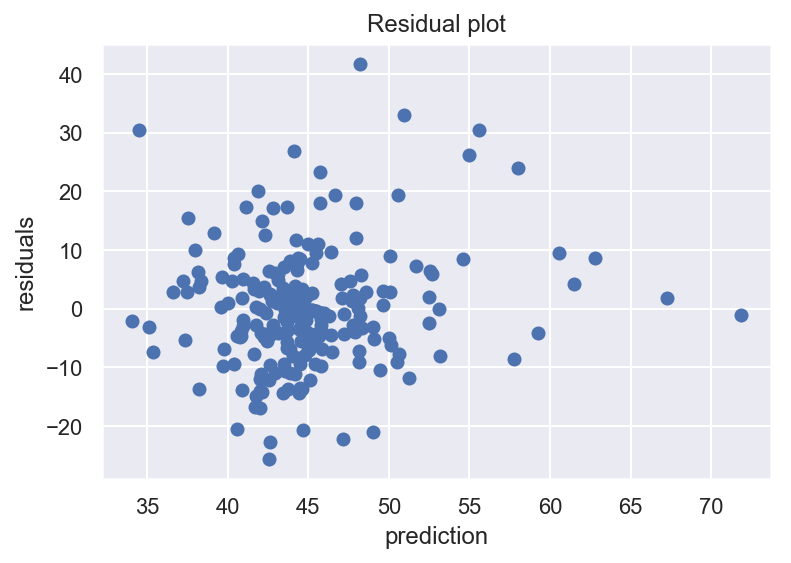

In [592]:
#ridge_pred = lasso.predict(X) 
y_pred_l = lasso.predict(X_scaled)
residuals = y - y_pred_l


plt.scatter(y_pred_l, residuals)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

print(residuals.mean())

Text(0,0.5,'frequency')

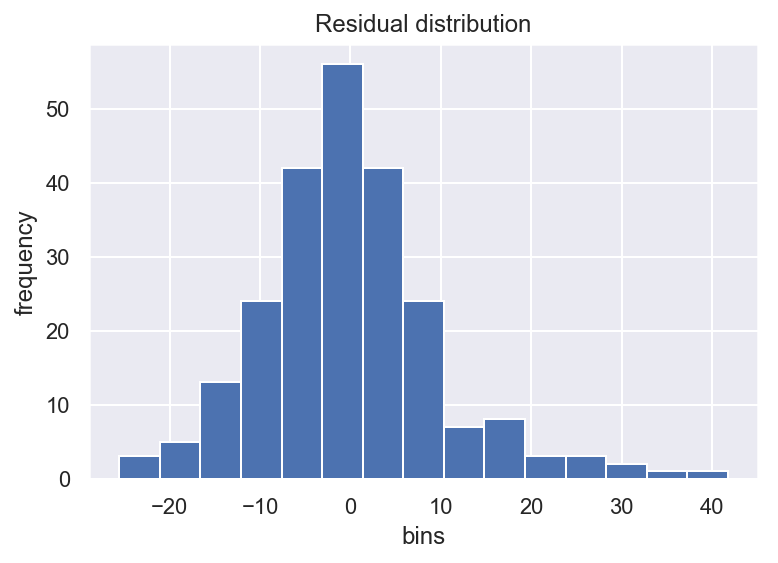

In [594]:
plt.hist(residuals,bins=15)
plt.title("Residual distribution")
plt.xlabel("bins")
plt.ylabel("frequency")



(array([ 3.,  5., 17., 20., 37., 73., 28., 18., 13.,  6.,  6.,  3.,  0.,
         3.,  2.]),
 array([17.        , 21.86666667, 26.73333333, 31.6       , 36.46666667,
        41.33333333, 46.2       , 51.06666667, 55.93333333, 60.8       ,
        65.66666667, 70.53333333, 75.4       , 80.26666667, 85.13333333,
        90.        ]),
 <a list of 15 Patch objects>)

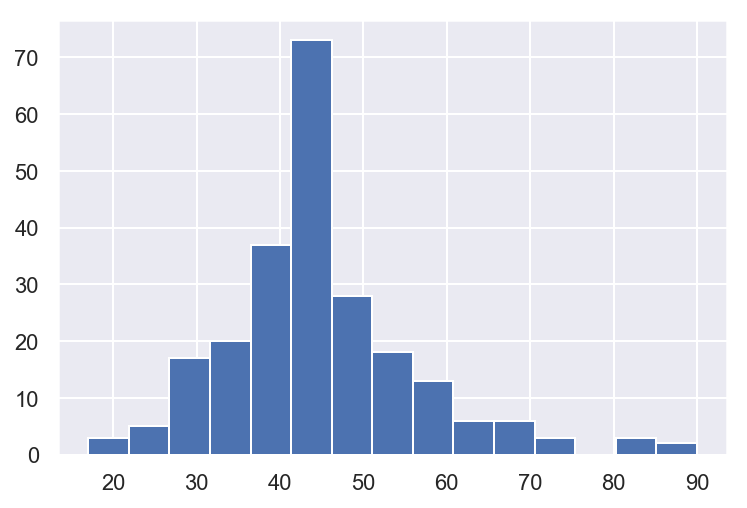

In [516]:
plt.hist(y,bins=15)

Text(0.5,1,'Normal Q-Q plot')

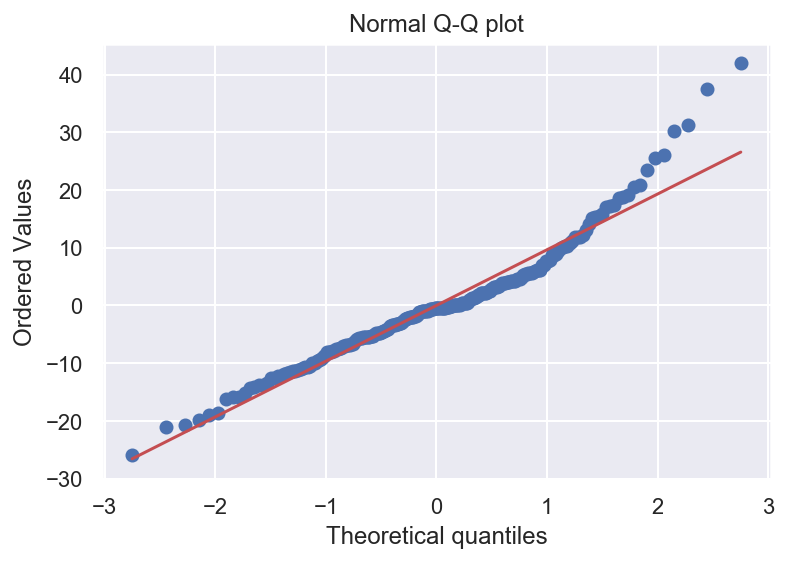

In [504]:
stats.probplot(ridge_errors, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

Text(0,0.5,'Actual')

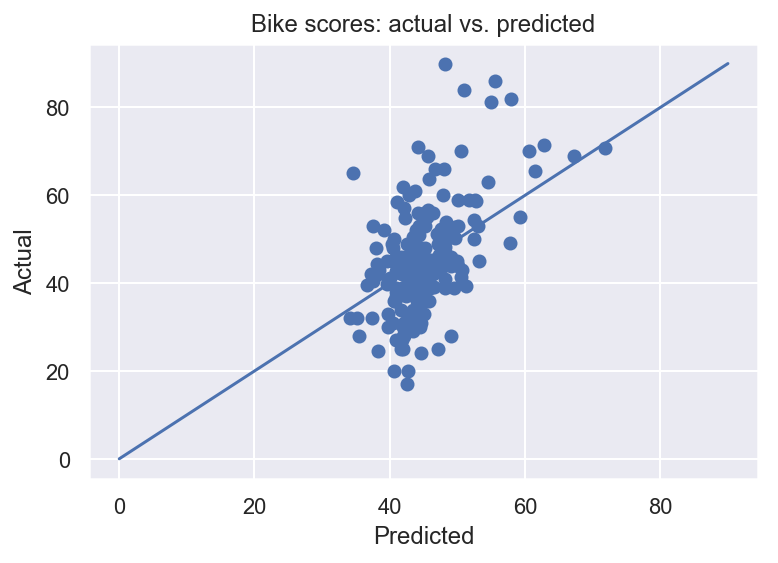

In [598]:
plt.scatter(y_pred_l,y)
plt.plot([0,90],[0,90])
plt.title("Bike scores: actual vs. predicted")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [520]:
df.head()

,pct_time_in_traffic,bus_per_sq_mi,percip_inches,density2019,state_tax,city_tax,total_tax,year_F,walk_score,transit_score,...,log_pop,pop_density_1/2,bike_score_x_walk_score,walk_score_x_transit_score,bus_per_sq_mi_x_density2019,density2019_x_transit_score,density2019_x_pop_density_1/2,city_tax_x_total_tax,transit_score_x_pop_density_1/2,population_x_log_pop
0,0.12,68.700000,12.8,3343.0,0.075,0.01500,0.09000,63.3,67.400000,51.500000,...,15.148568,57.818682,3713.740000,3471.100000,229664.100000,172164.500000,1.932879e+05,0.001350,2977.662128,5.745278e+07
1,0.13,79.000000,49.9,11056.0,0.040,0.04875,0.08875,55.3,43.773282,33.614184,...,12.293833,105.147515,1972.089776,1471.403188,873424.000000,371638.422695,1.162511e+06,0.004327,3534.447972,2.684302e+06
2,0.12,47.900000,20.7,7388.0,0.075,0.01250,0.08750,58.2,86.000000,80.400000,...,13.598889,85.953476,6080.200000,6914.400000,353885.200000,593995.200000,6.350243e+05,0.001094,6910.659453,1.095030e+07
3,0.10,30.161538,49.7,1450.0,0.040,0.04000,0.08000,62.3,49.200000,46.000000,...,12.948017,38.078866,2036.880000,2263.200000,43734.230769,66700.000000,5.521436e+04,0.003200,1751.627814,5.438206e+06
4,0.09,33.100000,61.9,5276.0,0.060,0.01000,0.07000,76.9,79.200000,57.200000,...,12.897861,72.636079,4989.600000,4530.240000,174635.600000,301787.200000,3.832280e+05,0.000700,4154.783730,5.152141e+06


***

In [475]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, y_pred)

10.681752183421588

In [434]:
r2s = defaultdict(list)
r2as = defaultdict(list)

lm_r2 = [] 

models = [lm, ridge, lasso]

for m in models:
    for train_xy, val_xy in kf.split(X,y):
    
        X_train, y_train = X.iloc[train_xy], y.iloc[train_xy]
        X_val, y_val = X.iloc[val_xy], y.iloc[val_xy] 
    
    #OLS Model
    lm_r2 = []
    lm_r2_a = []
    lm_mae = []
    
    m.fit(X_train, y_train)
    
    r2 = lm.score(X_val, y_val)
    lm_r2.append(r2)
    r2s['lm'].append(lm_r2)
    
    lm_r2_a.append(r2_adj(X_val,y_val,r2))
    r2as['lm'].append(lm_r2_a)
    
    lm_r2.append(lm.score(X_val,y_val))
    
    #RIDGE Model
    ridge.fit(X_train, y_train)
    r2 = ridge.score(X_val, y_val)
    #r2s.append(r2)
    #r2_adjs.append(r2_adj(X_val,y_val,r2))
    
    #LASSO Model
    #lasso_model = Lasso(alpha = .00044, max_iter = 60)
    #lasso_model.fit(X_train, y_train)
    #lm_r2.append(lasso_model.score(X_val,y_val))

#print('LASSO Model: ', lm_r2, '\n')

#print(f'LASSO Model cv r^2: {np.mean(lm_r2):.3f} +- {np.std(lm_r2):.3f}')

#list(zip(list(X.columns), lasso_model.coef_))



In [432]:
lm_r2

[0.24885629421699762, 0.24885629421699762]

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[X_cols].values)
X_val = X_val[X_train.columns]
X_val_scaled = scaler.transform(X_val[X_cols].values)
X_test = X_test[X_train.columns]
X_test_scaled = scaler.transform(X_test[X_cols].values)

#### Train-test-split

In [373]:
#X, y = df.drop('bike_score',axis=1), df['bike_score']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [374]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)


In [381]:
print(len(X), len(X_train), len(X_test), len(X_val))

234 156 59 78


*iii. R2 for different cominations of features*

In [275]:
X_train.head()

,const,pct_time_in_traffic,bus_per_sq_mi,pop_density_1/2,log_pop,percip_inches,year_F,total_tax,gdp_per_cap_17,city_tax,state_tax,transit_score
181,1.0,0.05,30.161538,40.348482,11.678711,45.35000,51.050000,0.076972,45938.0,0.019637,0.060000,36.000000
2,1.0,0.12,47.900000,85.953476,13.598889,20.70000,58.200000,0.087500,89978.0,0.012500,0.075000,80.400000
56,1.0,0.06,30.161538,39.585351,13.996010,37.60000,66.200000,0.082500,64824.0,0.020000,0.062500,39.700000
902,1.0,0.06,30.161538,23.895606,11.638527,38.08000,64.850000,0.076972,42012.0,0.019637,0.062500,33.614184
1135,1.0,0.04,30.161538,40.348482,10.300652,37.75589,58.111765,0.076972,44997.0,0.019637,0.058409,33.614184


In [368]:
#set up the 3 models we're choosing from:
lm = LinearRegression()


In [369]:
lsm = sm.OLS(y_train,X_train[X_cols])

fit = lsm.fit()

fit.summary()

#fit.score(X_val,y_val)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_score   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     5.250
Date:                Thu, 24 Jan 2019   Prob (F-statistic):           4.57e-07
Time:                        14:16:48   Log-Likelihood:                -647.59
No. Observations:                 175   AIC:                             1319.
Df Residuals:                     163   BIC:                             1357.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  25.6537     15.763      1.627      0.106      -5.472      56.779
pct_time_in_traffic    72.4218     37.656      1.923      0.056      -1.935     146.779
bus_per_sq_mi          -0.3900      0.184     -2.117      0.036      -0.754      -0.026
pop_density_1/2         0.2349      0.119      1.979      0.050       0.001       0.469
log_pop                 0.3951      1.000      0.395      0.693      -1.579       2.369
percip_inches          -0.1536      0.066     -2.316      0.022      -0.285      -0.023
year_F                 -0.1024      0.113     -0.909      0.365      -0.325       0.120
total_tax             203.6523    200.411      1.016      0.311    -192.085     599.389
gdp_per_cap_17        2.41e-05   8.05e-05      0.299      0.765      -0.000       0.000
city_tax             -118.8411    163.897     -0.725      0.469    -442.476     204.794
state_tax               8.4168     94.670      0.089      0.929    -178.520     195.354
transit_score           0.3105      0.121      2.573      0.011       0.072       0.549
==============================================================================
Omnibus:                       29.544   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.651
Skew:                           0.836   Prob(JB):                     3.69e-12
Kurtosis:                       5.104   Cond. No.                     1.54e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**B. regularized regressions**

In [295]:
#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[X_cols].values)
X_val = X_val[X_train.columns]
X_val_scaled = scaler.transform(X_val[X_cols].values)
X_test = X_test[X_train.columns]
X_test_scaled = scaler.transform(X_test[X_cols].values)

In [283]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

def r2_adj(X,Y,r_squared):
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return(adjusted_r_squared)

*ii. Ridge regression*

min mae is: 6.998284989153748  with alpha: 23.81685551976158


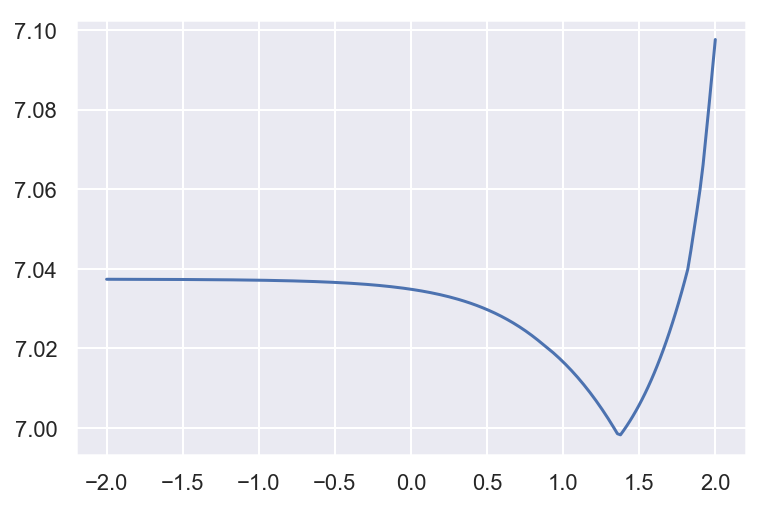

In [296]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_scaled, y_train)
    
    val_set_pred = pipe.predict(X_val_scaled)
    err_vec_val[i] = mae(y_val, val_set_pred)

#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

print('min mae is:',np.min(err_vec_val),' with alpha:', alphalist[np.argmin(err_vec_val)])

In [297]:
lr_model_ridge = Ridge(alpha = 23.81685551976158)
lr_model_ridge.fit(X_train_scaled, y_train)

print('Ridge Regression val adjusted R^2:',r2_adj(X_train_scaled,y_train,lr_model_ridge.score(X_train_scaled, y_train)).round(3))

print(f'Ridge Regression val R^2: {lr_model_ridge.score(X_train_scaled, y_train):.3f}')

list(zip(X_train.columns, lr_model_ridge.coef_))


Ridge Regression val adjusted R^2: 0.218
Ridge Regression val R^2: 0.259


[('const', 0.0),
 ('pct_time_in_traffic', 1.5923550408880611),
 ('bus_per_sq_mi', -1.5653931335488902),
 ('percip_inches', 1.8466394682231704),
 ('density2019', 0.2999169188643134),
 ('state_tax', -1.7084283878136561),
 ('city_tax', -0.7581425407558942),
 ('total_tax', 0.81181600090077),
 ('year_F', 0.4215596398735667),
 ('walk_score', -0.5837434311107648),
 ('transit_score', 0.29821849887884005),
 ('population', 2.4660662054946356)]

*iii. Lasso regression*

In [308]:
#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[X_cols2].values)
X_val = X_val[X_train[X_cols2].columns]
X_val_scaled = scaler.transform(X_val.values)
X_test = X_test[X_train.columns]
X_test_scaled = scaler.transform(X_test[X_cols2].values)

min mae is: 6.613473975385414  with alpha: 0.8119844993184013


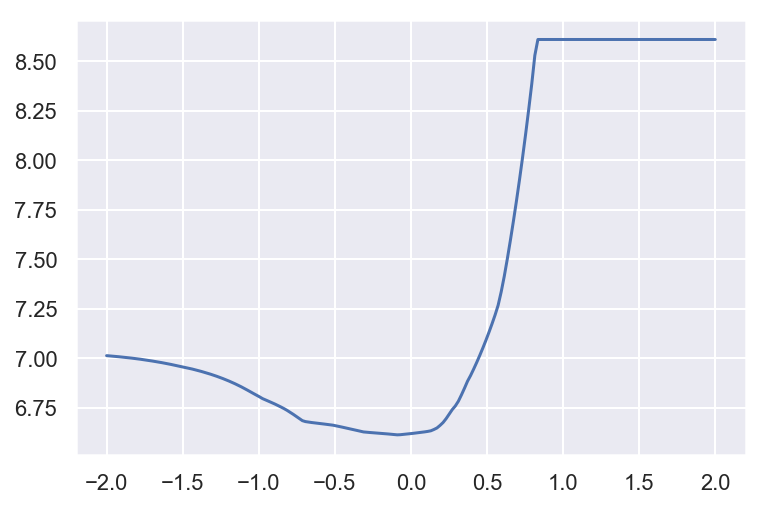

In [309]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_scaled, y_train)
    
    val_set_pred = pipe.predict(X_val_scaled)
    err_vec_val[i] = mae(y_val, val_set_pred)

#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

print('min mae is:',np.min(err_vec_val),' with alpha:', alphalist[np.argmin(err_vec_val)])

In [310]:
lr_model_lasso = Lasso(alpha = 0.8119844993184013)
lr_model_lasso.fit(X_train_scaled, y_train)


print('Lasso Regression val adjusted R^2:',r2_adj(X_train_scaled,y_train,lr_model_lasso.score(X_train_scaled, y_train)).round(3))

print(f'Lasso Regression val R^2: {lr_model_lasso.score(X_train_scaled, y_train):.3f}')


list(zip(X_train.columns, lr_model_lasso.coef_))

Lasso Regression val adjusted R^2: 0.345
Lasso Regression val R^2: 0.381


[('const', 0.0),
 ('pct_time_in_traffic', 0.4502361382391573),
 ('bus_per_sq_mi', -1.39684615450601),
 ('percip_inches', 0.0),
 ('density2019', -0.0),
 ('state_tax', 0.0),
 ('city_tax', 0.0),
 ('total_tax', 5.3467706761826825),
 ('year_F', 0.5249105463041108),
 ('walk_score', 0.0),
 ('transit_score', 0.0),
 ('population', 0.0),
 ('gdp_per_cap_17', 0.0)]

In [307]:
X_cols2 = ['const', 
'pct_time_in_traffic', 
'percip_inches',
'state_tax',
'city_tax', 
'total_tax',
'year_F', 
'walk_score',
'transit_score', 
'gdp_per_cap_17',
'log_pop', 
'pop_density_1/2', 
'density2019_x_transit_score']


In [316]:
lsm = sm.OLS(y_train,X_train[['const','pct_time_in_traffic', 'bus_per_sq_mi','total_tax','year_F']])

fit = lsm.fit()

fit.summary()

#fit.score(X_val,y_val)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5.543
Date:                Thu, 24 Jan 2019   Prob (F-statistic):           0.000322
Time:                        12:35:52   Log-Likelihood:                -663.40
No. Observations:                 175   AIC:                             1337.
Df Residuals:                     170   BIC:                             1353.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  50.1547     12.189      4.115      0.000      26.094      74.216
pct_time_in_traffic   154.1580     35.028      4.401      0.000      85.012     223.304
bus_per_sq_mi          -0.1636      0.164     -0.995      0.321      -0.488       0.161
total_tax              46.2825    136.145      0.340      0.734    -222.470     315.035
year_F                 -0.2050      0.107     -1.917      0.057      -0.416       0.006
==============================================================================
Omnibus:                       19.734   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.863
Skew:                           0.593   Prob(JB):                     7.31e-08
Kurtosis:                       4.761   Cond. No.                     1.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***

In [486]:
lms = {}
for i, x in enumerate(X_trains):
    lsm = sm.OLS(y_train,x)
    fit = lsm.fit()
    fit.summary()
    lms['X_train'+str(i+1)] = (fit.rsquared, fit.rsquared_adj)

X_train_final = globals()[max(lms.items(), key=operator.itemgetter(1))[0]]

In [478]:
X_train.head()

,bus_per_sq_mi,percip_inches,state_tax,city_tax,year_F,walk_score,transit_score,bike_score,log_pop,pop_density_1/2,walk_score_x_bike_score,density2019_x_pop_density_1/2
168,30.161538,45.35000,0.060000,0.019637,51.050000,66.0,36.000000,41.0,11.678711,40.348482,2706.00,65687.328702
4,47.900000,20.70000,0.075000,0.012500,58.200000,86.0,80.400000,70.7,13.598889,85.953476,6080.20,635024.279120
21,30.161538,37.60000,0.062500,0.020000,66.200000,46.2,39.700000,46.4,13.996010,39.585351,2143.68,62030.244744
872,30.161538,38.08000,0.062500,0.019637,64.850000,33.0,33.614184,39.0,11.638527,23.895606,1287.00,13644.391192
1057,30.161538,37.75589,0.058409,0.019637,58.111765,21.0,33.614184,30.0,10.300652,40.348482,630.00,65687.328702


In [206]:
X = add_constant(df[['pct_time_in_traffic', 'percip_inches', 
                     'bus_per_sq_mi','pop_density_1/2', 'log_pop',
                      'year_F', 'transit_score',
                     'total_tax', 'gdp_per_cap_17', 
                     ]])
y = df['bike_score']

In [185]:
df.columns

Index(['pct_time_in_traffic', 'bus_per_sq_mi', 'percip_inches', 'density2019',
       'state_tax', 'city_tax', 'total_tax', 'year_F', 'walk_score',
       'transit_score', 'bike_score', 'population', 'gdp_per_cap_17',
       'log_pop', 'pop_density_1/2', 'bike_score_x_walk_score',
       'walk_score_x_transit_score', 'bus_per_sq_mi_x_density2019',
       'density2019_x_transit_score', 'density2019_x_pop_density_1/2',
       'city_tax_x_total_tax', 'transit_score_x_pop_density_1/2',
       'population_x_log_pop'],
      dtype='object')

#### Train-test-split (walk/bike score as Y)

In [498]:
X, y = df.drop('bike_score',axis=1), df['bike_score']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [499]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)


In [500]:
print(len(X), len(X_train), len(X_test), len(X_val))

234 175 59 59


*iii. R2 for different cominations of features*

In [501]:
#set up the 3 models we're choosing from:

lm = LinearRegression()


In [513]:
X_train_bike['pop_density_1/2_x_pct_time_in_traffic'].head()

168      2.017424
4       10.314417
21       2.375121
872      1.433736
1057     1.613939
Name: pop_density_1/2_x_pct_time_in_traffic, dtype: float64

In [523]:
X_train['pop_density_1/2_x_pct_time_in_traffic'] = X_train['pop_density_1/2']*X_train['pct_time_in_traffic']

X_train_bike = add_constant(X_train[['bus_per_sq_mi', 'percip_inches', 
       'total_tax', 'year_F', 'walk_score',
       'transit_score',  'log_pop','pop_density_1/2_x_pct_time_in_traffic']])



In [503]:
#lms = {}
#for i, x in enumerate(X_trains):
 #   lsm = sm.OLS(y_train,x)
 #   fit = lsm.fit()
  #  fit.summary()
  #  lms['X_train'+str(i+1)] = (fit.rsquared, fit.rsquared_adj)

#X_train_final = globals()[max(lms.items(), key=operator.itemgetter(1))[0]]

In [504]:
X_train_bike.head()

,const,bus_per_sq_mi,percip_inches,density2019,state_tax,city_tax,total_tax,year_F,walk_score,transit_score,log_pop,pop_density_1/2,pct_time_in_traffic
168,1.0,30.161538,45.35000,1628.0,0.060000,0.019637,0.076972,51.050000,66.0,36.000000,11.678711,40.348482,0.05
4,1.0,47.900000,20.70000,7388.0,0.075000,0.012500,0.087500,58.200000,86.0,80.400000,13.598889,85.953476,0.12
21,1.0,30.161538,37.60000,1567.0,0.062500,0.020000,0.082500,66.200000,46.2,39.700000,13.996010,39.585351,0.06
872,1.0,30.161538,38.08000,571.0,0.062500,0.019637,0.076972,64.850000,33.0,33.614184,11.638527,23.895606,0.06
1057,1.0,30.161538,37.75589,1628.0,0.058409,0.019637,0.076972,58.111765,21.0,33.614184,10.300652,40.348482,0.04


In [524]:
lsm = sm.OLS(y_train,X_train_bike)

fit = lsm.fit()

fit.summary()

#fit.score(X_val,y_val)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_score   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     13.80
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           2.88e-15
Time:                        17:04:29   Log-Likelihood:                -629.51
No. Observations:                 175   AIC:                             1277.
Df Residuals:                     166   BIC:                             1306.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    24.5605     13.215      1.859      0.065      -1.531      50.652
bus_per_sq_mi                            -0.1961      0.167     -1.175      0.242      -0.526       0.133
percip_inches                            -0.1846      0.057     -3.263      0.001      -0.296      -0.073
total_tax                                85.5445    114.339      0.748      0.455    -140.201     311.290
year_F                                    0.0868      0.098      0.882      0.379      -0.108       0.281
walk_score                                0.4468      0.069      6.448      0.000       0.310       0.584
transit_score                             0.0874      0.109      0.804      0.423      -0.127       0.302
log_pop                                  -0.1880      0.797     -0.236      0.814      -1.762       1.386
pop_density_1/2_x_pct_time_in_traffic     0.7234      0.655      1.105      0.271      -0.570       2.016
==============================================================================
Omnibus:                       39.724   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.840
Skew:                           0.974   Prob(JB):                     2.55e-21
Kurtosis:                       6.036   Cond. No.                     1.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [399]:
#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val = X_val[X_train.columns]
X_val_scaled = scaler.transform(X_val.values)
X_test = X_test[X_train.columns]
X_test_scaled = scaler.transform(X_test.values)

In [394]:

lm_ridge = Ridge(alpha=1, fit_intercept=False)

In [398]:
lm_ridge.fit(X_train, y_train)

print(f'Ridge Regression val R^2: {lm_ridge.score(X_train_scaled, y_train):.3f}')
list(zip(X_train.columns, lm_ridge.coef_))

Ridge Regression val R^2: -4.886


[('bus_per_sq_mi', 0.00046806458189626855),
 ('percip_inches', -0.000249081115767383),
 ('state_tax', 0.002639425200863059),
 ('city_tax', 0.002025499765727442),
 ('year_F', 0.00048076200406251034),
 ('walk_score', -0.0004973708898346555),
 ('transit_score', 0.0003339362669584066),
 ('bike_score', -0.0006402171131515233),
 ('log_pop', 0.002430660243624844),
 ('pop_density_1/2', -0.0002278890199530879),
 ('walk_score_x_bike_score', 1.8011710985396467e-05),
 ('density2019_x_pop_density_1/2', 5.668177184003378e-08)]

In [413]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression(fit_intercept=False)
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [412]:
X = df[['bus_per_sq_mi', 'percip_inches', 'state_tax', 'city_tax', 'year_F',
       'walk_score', 'transit_score', 'bike_score', 'log_pop',
       'pop_density_1/2', 'walk_score_x_bike_score',
       'density2019_x_pop_density_1/2']]
y = df['pct_time_in_traffic']

In [414]:
split_and_validate(X, y)


Validation R^2 score was: 0.26544307143835344
Feature coefficient results: 

bus_per_sq_mi : -0.00
percip_inches : -0.00
state_tax : 0.44
city_tax : 0.32
year_F : 0.00
walk_score : -0.00
transit_score : 0.00
bike_score : -0.00
log_pop : 0.00
pop_density_1/2 : -0.00
walk_score_x_bike_score : 0.00
density2019_x_pop_density_1/2 : 0.00


**Standard scaling regularization**

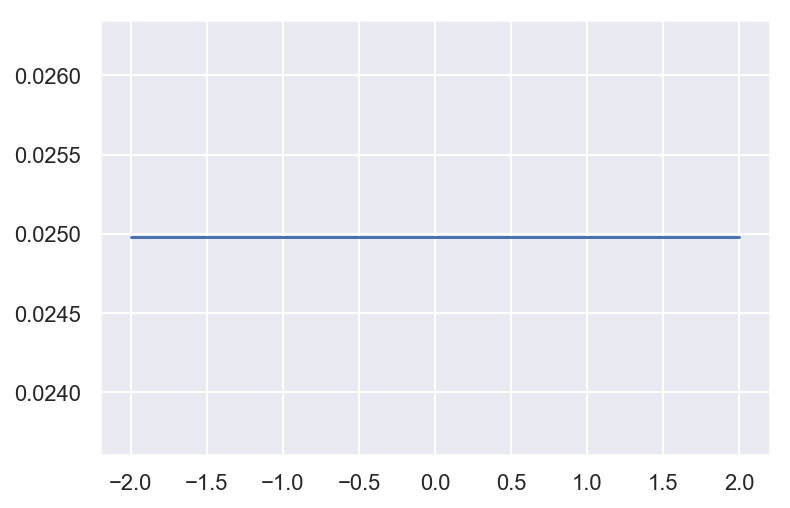

In [387]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)
    
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)


In [391]:
#Feature transforms for train, val, and test so that we can run our poly model on each
lm_lasso = Lasso(alpha = 0.01)
lm_lasso.fit(X_train_scaled, y_train)

print(f'Lasso Regression val R^2: {lm_lasso.score(X_train_scaled, y_train):.3f}')

list(zip(X_train.columns, lm_lasso.coef_))


Lasso Regression val R^2: 0.000


[('bus_per_sq_mi', 0.0),
 ('percip_inches', -0.0),
 ('state_tax', 0.0),
 ('city_tax', 0.0),
 ('year_F', 0.0),
 ('walk_score', 0.0),
 ('transit_score', 0.0),
 ('bike_score', 0.0),
 ('log_pop', 0.0),
 ('pop_density_1/2', 0.0),
 ('walk_score_x_bike_score', 0.0),
 ('density2019_x_pop_density_1/2', 0.0)]

In [386]:
np.min(err_vec_val)
alphalist[np.argmin(err_vec_val)]

0.01

In [375]:
len(X_val.columns)

12

In [374]:
X_val = X_val[X_train.columns]

In [376]:
len(X_val)

59

In [469]:
state_aggs = df_all.groupby(['state'])['pct_time_in_traffic', 'walk_score','state_tax'].mean().reset_index()
state_aggs.head()

,state,pct_time_in_traffic,walk_score,state_tax
0,AL,0.041429,27.471429,0.040
1,AR,0.033333,31.000000,NaN
2,AZ,0.056667,34.733333,0.056
3,CA,0.078387,48.425000,0.075
4,CO,0.070000,46.400000,0.029


Text(0,0.5,'Traffic index')

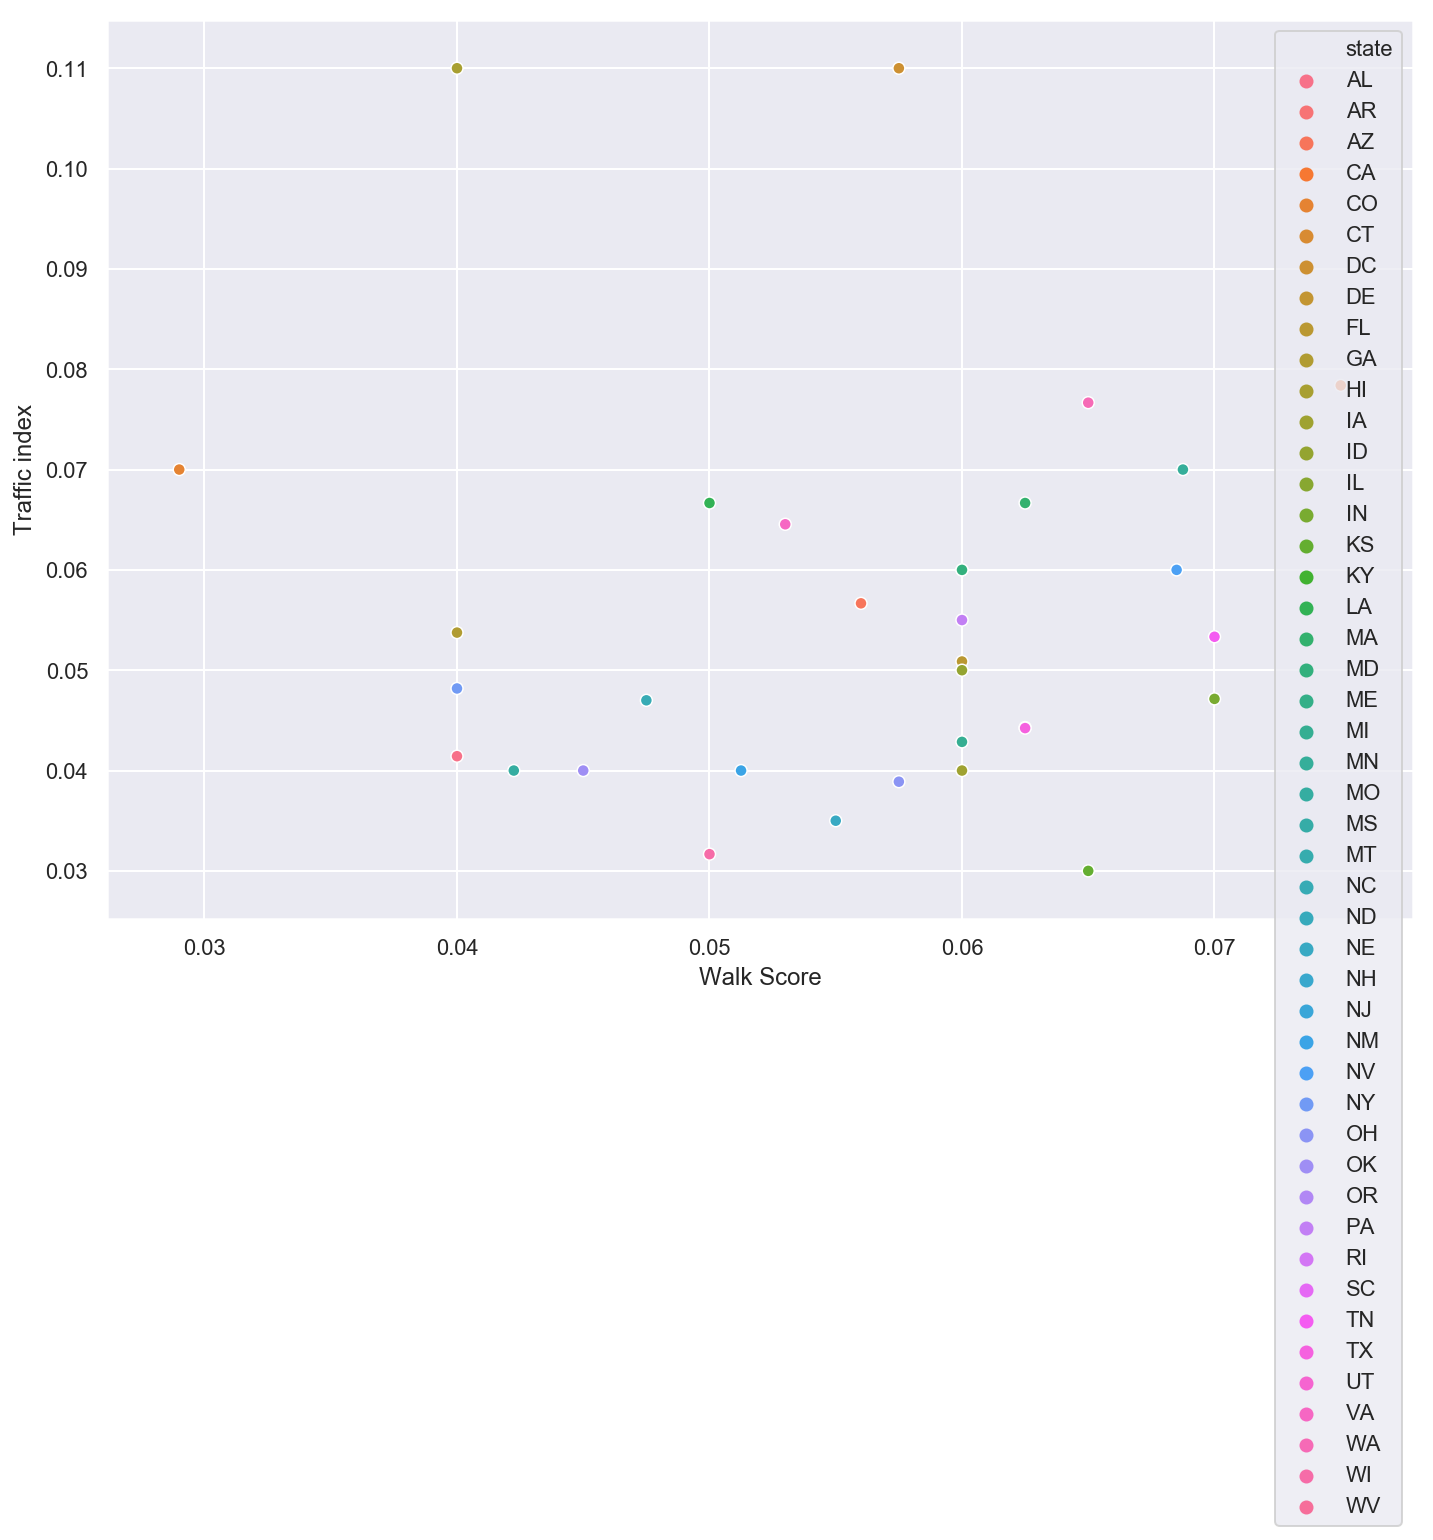

In [470]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=state_aggs, x="state_tax", y="pct_time_in_traffic", hue = "state")
plt.xlabel('Walk Score')
plt.ylabel('Traffic index')
